# **LLM agents**
Agentic pipeline for LLM adds additional properties to "Reason and take Action" as per feedback loop.


        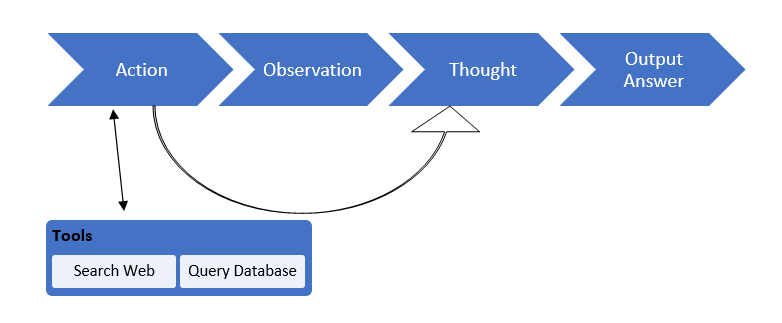

In [ ]:
!pip install -r requirements.txt

In [11]:
from dotenv import load_dotenv
from langchain import hub
from langchain.agents import (AgentExecutor, create_react_agent)
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI

In [12]:
# Start building pipelines be intiating the model

# load enviroment variables and API_KEYs
load_dotenv()

# create tool function
def get_current_time() -> str:
    """Get the current time in proper format."""
    import datetime
    return datetime.datetime.now().strftime("%I:%M:%S %p")

In [13]:
# assemble all the created tools

first_tools = [
    Tool(
        name="Current_Time",
        func=get_current_time, # tool function
        description="Get the current time in proper format."
    )
]

# Getting current time is out of scope for any LLMs because it is only trained on
# older data. Thus we need to add this tools which will help LLMs to access these data.

In [ ]:
# Getting ReAct pronpt template from
# github: https://github.com/hwchase17/langchain-hub
# This template will teach LLM, how to act and reason in recurssive way
prompt = hub.pull("hwchase17/react")


# Initialize chatmodel
chatmodel = ChatOpenAI(model="gpt-4o")

# Initialize react agent
react_agent = create_react_agent(
    llm=chatmodel,
    tools=first_tools,
    prompt=prompt,
    stop_sequence=True
)

In [ ]:
# Creating the agent Executor to execute the agent
agent_executor= AgentExecutor.from_agent_and_tools(
    agent=react_agent,
    tools=first_tools,
    verbose=True
)

# executing and querying the prompt

react_answer = agent_executor.invoke({"input":"What is the current time now?"})

print("answer: ", react_answer)


# Building Agents with multiple tools

There can various scenarios where we may need multiple tools to execute the "reAct" tasks.

In [15]:
# Apart from above tools, We will have other tools which will retrieve data from
# other sources like Web based source

from langchain_openai import ChatOpenAI
from langchain import chains, vectorstores
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader
import os
import PyPDF2
import pypdf
import re
from langchain.embeddings import HuggingFaceEmbeddings

In [19]:
# Start building Retriever pipelines be intiating the model

# load enviroment variables and API_KEYs
load_dotenv()


# instantiate Embeddings
def init_embeddings():
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
  return embeddings

# load the pdf documents and load its contents for further processing
def load_pdf_document(pdfPath):
  pdf_document = PyPDFLoader(pdfPath)
  documents = pdf_document.load()
  return documents

# split the documents into multiple chunks(of size 1000 tokens) for indexing
def split_pdf_documents(documents):
  doc_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
  docs = doc_splitter.split_documents(documents)
  return docs

def create_vectorDB_store(textdocs, embeddingFun):
  vectorDB = vectorstores.Chroma.from_documents(textdocs, embeddingFun)
  return vectorDB

def get_retrieved_docs(n_documents, stored_VectorDB):
  retrieved_docs = stored_VectorDB.as_retriever(search_type="similarity", search_kwargs={"k":n_documents})
  return retrieved_docs

In [ ]:
loaded_docs = load_pdf_document("/content/sell_my_dream.pdf")
textdocs = split_pdf_documents(loaded_docs)
print("chunk size: ", len(textdocs))
vectordb = create_vectorDB_store(textdocs, embeddingFun=init_embeddings())
retrievers = get_retrieved_docs(3, vectordb)

In [21]:
# creating retriever tool
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retrievers,
    "document_search",
    "Search for relevant information about PDF document using this tool!",
)

In [22]:
# combining multiple tools togther

tools = [first_tools, retriever_tool]

In [23]:
# Getting new Pronpt template for multi-tools
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [ ]:
# Create and initialize tool calling agents
from langchain.agents import create_tool_calling_agent

mulitToolAgent = create_tool_calling_agent(chatmodel, tools, prompt)

In [ ]:
multiAgentExecutor = AgentExecutor.from_agent_and_tools(
    agent=mulitToolAgent,
    tools=tools,
    verbose=True
)

In [ ]:
# executing and querying the prompt on multi-tools agent

react_answer1 = multiAgentExecutor.invoke({"input":"What is the current time now?"})

print("answer: ", react_answer1)

In [ ]:
# We can also add Chat history to provide extra context
from langchain_core.messages import AIMessage, HumanMessage
react_answer2 = multiAgentExecutor.invoke({"input":"What is the tomorrow date?",
                                           "chat_history":[
                                               HumanMessage(content="What is the current time now?"),
                                               AIMessage(content="Hello ! How can I assist you today?"),
                                           ]})
